In [ ]:
!pip install -U torchtext==0.17.0

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

## Câu hỏi 1: **M08QA01**
### Động lực:
Với phương pháp Extractive của bài toán Question Answering (QA), giai đoạn tiền xử lý dữ liệu của các bộ dữ liệu cho bài toán QA (ví dụ như: bộ SQuAD, Natural Questions, TyDi QA, ...) thường có các thuộc tính tương tự câu hỏi bên dưới, do đó cần nắm phải rõ cách xử lý chúng.

### Mô tả:
Cho một mẫu dữ liệu gồm 5 thuộc tính sau: Question, Context, Answer, Start, End. Trong đó:
- Question: Câu hỏi.
- Context: Ngữ cảnh được cung cấp sẵn.
- Answer: Câu trả lời (nhãn/label).
- Start: Vị trí bắt đầu Answer.
- End: Vị trí kết thức Answer.
Ví dụ: Trong câu Context: "AIOers are very smart" sẽ có Start là 2 (hay "very") và End là 3 (hay "smart").

### Câu hỏi:
Cho trước bộ từ vựng (Vocabulary), hãy:
1. Nối Question và Context lại với nhau và ngăn cách bằng token đặc biệt `sep`, sau đó tokenize, vectorize và padding để có được `Input ids`. Lưu ý: `max_sequence_length = 9`
2. Cập nhật Start và End mới cho câu đã nối Question và Context trên để có `New Start` và `New End`.

### Chọn đáp án:
A. **Input ids:** [5, 4, 2, 1, 3, 4, 0, 7, 1],    **New Start:** 6,    **New End:** 6

B. **Input ids:** [5, 4, 3, 2, 3, 4, 0, 7, 1],    **New Start:** 6,    **New End:** 7

C. **Input ids:** [5, 4, 3, 2, 3, 4, 0, 7, 1],    **New Start:** 6,    **New End:** 6

D. **Input ids:** [5, 4, 2, 3, 7, 4, 0, 3, 1],    **New Start:** 6,    **New End:** 7

### Đáp án: B

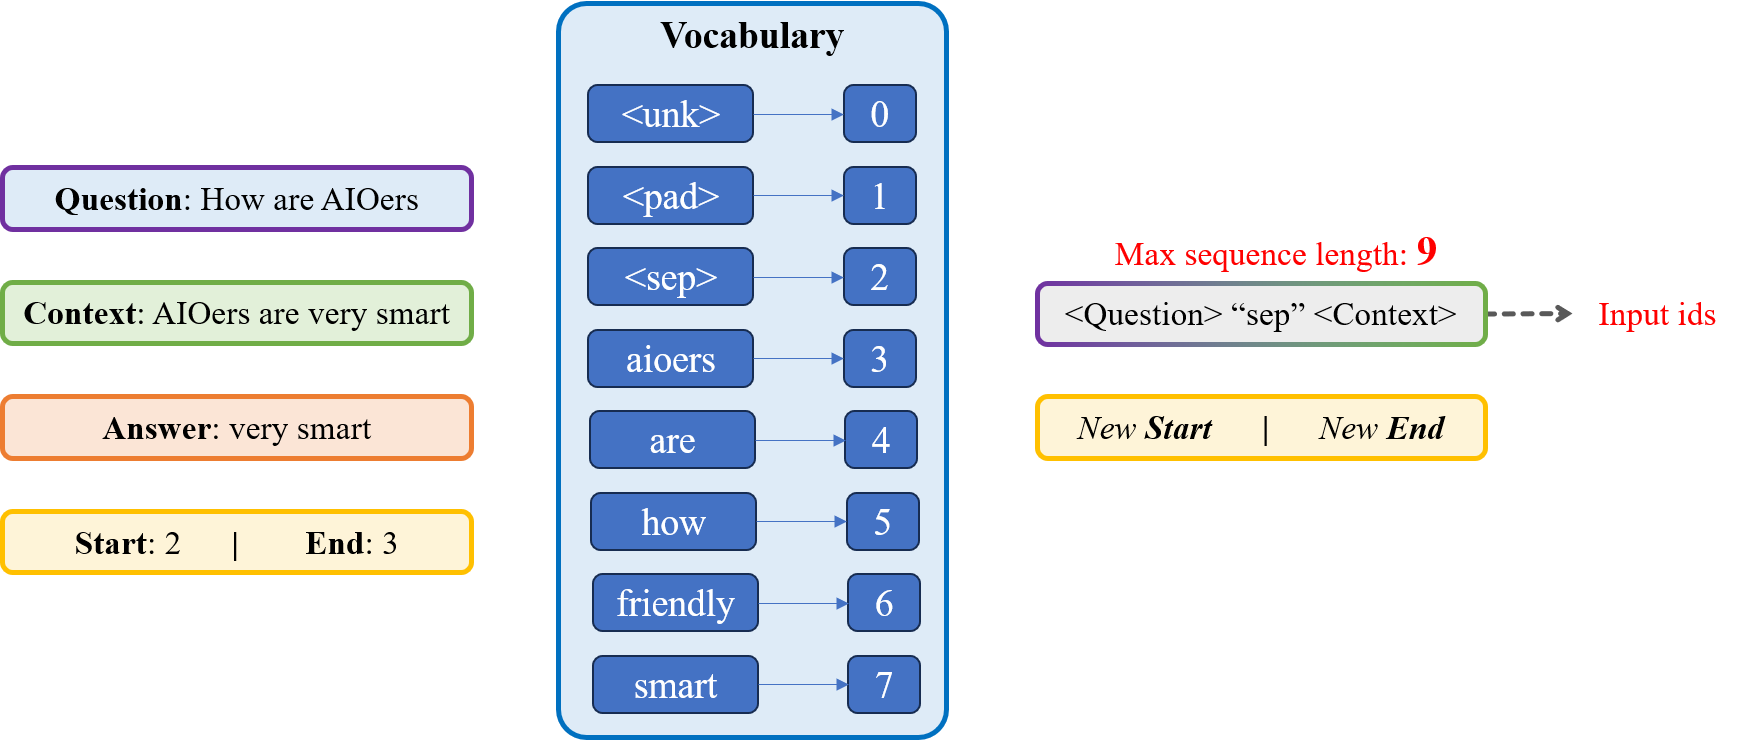

```
Input Text: How are AIOers <sep> AIOers are very smart
Input Tokens: [5, 4, 3, 2, 3, 4, 0, 7] , Length: 8
Context Vector: [5, 4, 3, 2, 3, 4, 0, 7, 1] , Length: 9
Answer Tokens: [0, 7] , Length: 2
New Start: 6, New End: 7
Input Vector: tensor([5, 4, 3, 2, 3, 4, 0, 7, 1]), Size: torch.Size([9])
New Start: 6, Size: torch.Size([])
New End: 7, Size: torch.Size([])
```



In [ ]:
qa_dataset = [
    {
        "context": "AIOers are very smart",
        "question": "How are AIOers",
        "answer": "very smart",
        "start": 2,
        "end": 3
    },
    {
        "context": "AIOers are friendly",
        "question": "How are AIOers",
        "answer": "friendly",
        "start": 2,
        "end": 2
    },
]

In [ ]:
for sample in qa_dataset:
    print(f"Question: {sample['question']}")
    print(f"Context: {sample['context']}")
    print(f"Answer:' {sample['answer']} (Start: {sample['start']}, End: {sample['end']})")
    print("-" * 50)

Question: How are AIOers
Context: AIOers are very smart
Answer: very smart (Start: 2, End: 3)
--------------------------------------------------
Question: How are AIOers
Context: AIOers are friendly
Answer: friendly (Start: 2, End: 2)
--------------------------------------------------


In [ ]:
MAX_TOKENS = 8
# Define tokenizer function
tokenizer = get_tokenizer("basic_english")

# Create a function to yeild list of tokens
def yield_tokens(dataset):
    for sample in dataset:
        yield tokenizer(sample["question"] + ' ' + sample["context"])

# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(qa_dataset),
                                  specials=["<unk>", "<pad>", "<sep>"],
                                  max_tokens=MAX_TOKENS)
vocab.set_default_index(vocab["<unk>"])  # Set unknown token index

# Print vocabulary mappings
print("Vocabulary Mapping:")
sorted_vocab = sorted(vocab.get_stoi().items(), key=lambda x: x[1])
for word, index in sorted_vocab:
    print(f"{word}: {index}")

Vocabulary Mapping:
<unk>: 0
<pad>: 1
<sep>: 2
aioers: 3
are: 4
how: 5
friendly: 6
smart: 7


In [ ]:
MAX_SEQ_LENGTH = 9

def vectorize(sample, vocab):
    input_text = sample["question"] + " <sep> " + sample["context"]
    print(f"Input Text: {input_text}")

    input_ids = [vocab[token] for token in tokenizer(input_text)][:MAX_SEQ_LENGTH]
    print(f"Input Tokens: {input_ids} , Length: {len(input_ids)}")

    input_ids += [vocab["<pad>"]] * (MAX_SEQ_LENGTH - len(input_ids))  # Pad sequence
    print(f"Context Vector: {input_ids} , Length: {len(input_ids)}")

    answer_ids = [vocab[token] for token in tokenizer(sample["answer"])]
    print(f"Answer Tokens: {answer_ids} , Length: {len(answer_ids)}")

    start_pos = input_ids.index(answer_ids[0])
    end_pos = start_pos + len(answer_ids) - 1
    print(f"New Start: {start_pos}, New End: {end_pos}")

    input_ids = torch.tensor(input_ids, dtype=torch.long)
    print(f"Input Vector: {input_ids}, Size: {input_ids.size()}")
    start_pos = torch.tensor(start_pos, dtype=torch.long)
    print(f"New Start: {start_pos}, Size: {start_pos.size()}")
    end_pos = torch.tensor(end_pos, dtype=torch.long)
    print(f"New End: {end_pos}, Size: {end_pos.size()}")

    return input_ids, start_pos, end_pos

for sample in qa_dataset:
    sample["input_ids"], sample["start_token"], sample["end_token"] = vectorize(sample, vocab)
    print("-" * 50)

Input Text: How are AIOers <sep> AIOers are very smart
Input Tokens: [5, 4, 3, 2, 3, 4, 0, 7] , Length: 8
Context Vector: [5, 4, 3, 2, 3, 4, 0, 7, 1] , Length: 9
Answer Tokens: [0, 7] , Length: 2
New Start: 6, New End: 7
Input Vector: tensor([5, 4, 3, 2, 3, 4, 0, 7, 1]), Size: torch.Size([9])
New Start: 6, Size: torch.Size([])
New End: 7, Size: torch.Size([])
--------------------------------------------------
Input Text: How are AIOers <sep> AIOers are friendly
Input Tokens: [5, 4, 3, 2, 3, 4, 6] , Length: 7
Context Vector: [5, 4, 3, 2, 3, 4, 6, 1, 1] , Length: 9
Answer Tokens: [6] , Length: 1
New Start: 6, New End: 6
Input Vector: tensor([5, 4, 3, 2, 3, 4, 6, 1, 1]), Size: torch.Size([9])
New Start: 6, Size: torch.Size([])
New End: 6, Size: torch.Size([])
--------------------------------------------------


In [ ]:
def vectorize(sample, vocab):
    input_text = sample["question"] + " <sep> " + sample["context"]
    input_ids = [vocab[token] for token in tokenizer(input_text)][:MAX_SEQ_LENGTH]
    input_ids += [vocab["<pad>"]] * (MAX_SEQ_LENGTH - len(input_ids))
    answer_ids = [vocab[token] for token in tokenizer(sample["answer"])]
    start_pos = input_ids.index(answer_ids[0])
    end_pos = start_pos + len(answer_ids) - 1

    input_ids = torch.tensor(input_ids, dtype=torch.long)
    start_pos = torch.tensor(start_pos, dtype=torch.long)
    end_pos = torch.tensor(end_pos, dtype=torch.long)

    return input_ids, start_pos, end_pos

In [ ]:
class QADataset(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return vectorize(self.dataset[idx], self.vocab)

In [ ]:
train_dataset = QADataset(qa_dataset, vocab)
train_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True
)

for sample in train_loader:
    ids = sample[0].squeeze().tolist()
    detoken = ' '.join([vocab.get_itos()[id] for id in ids])
    print(detoken)
    print(sample)

how are aioers <sep> aioers are <unk> smart <pad>
[tensor([[5, 4, 3, 2, 3, 4, 0, 7, 1]]), tensor([6]), tensor([7])]
how are aioers <sep> aioers are friendly <pad> <pad>
[tensor([[5, 4, 3, 2, 3, 4, 6, 1, 1]]), tensor([6]), tensor([6])]


## Câu hỏi 2: **M08QA02**
### Động lực:
Sau khi biết cách tiền xử lý dữ liệu cho bài toán này, do kiến thức về mô hình LSTM và Linear đã khá quen thuộc với mọi người, nên chúng ta bỏ qua bước xây dựng và huấn luyện mô hình. Trong câu hỏi này, vì các mô hình Extractive QA sẽ trả về các giá trị index theo câu nối giữa Question và Context, do đó, ta cần hiểu cách xử lý chúng như thế nào.

### Mô tả:
- Cho một sample mới, chỉ gồm Question và Context, sau khi xử lý như câu hỏi trước được `Input ids` để truyền vào mô hình. Kiến trúc gồm 1 Embedding, 1 LSTM và 2 Linear, trong đó 1 Linear phụ trách dự đoán Start và Linear còn lại dự đoán End.
- Với sample này, mô hình trả về các giá trị Score tương ứng với các index trong câu nối.

### Câu hỏi:
Dựa vào các biểu đồ Score, kết hợp với chuyển đổi các vị trí index được mô hình dự đoán về vị trị gốc trong Context, từ đó, hãy cho biết câu trả lời được lấy ra từ Context là:

### Chọn đáp án:
A. "are friendly \<pad> \<pad>\"

B. "AIOers are friendly"

C. "are friendly"

D. "friendly"

### Đáp án: C

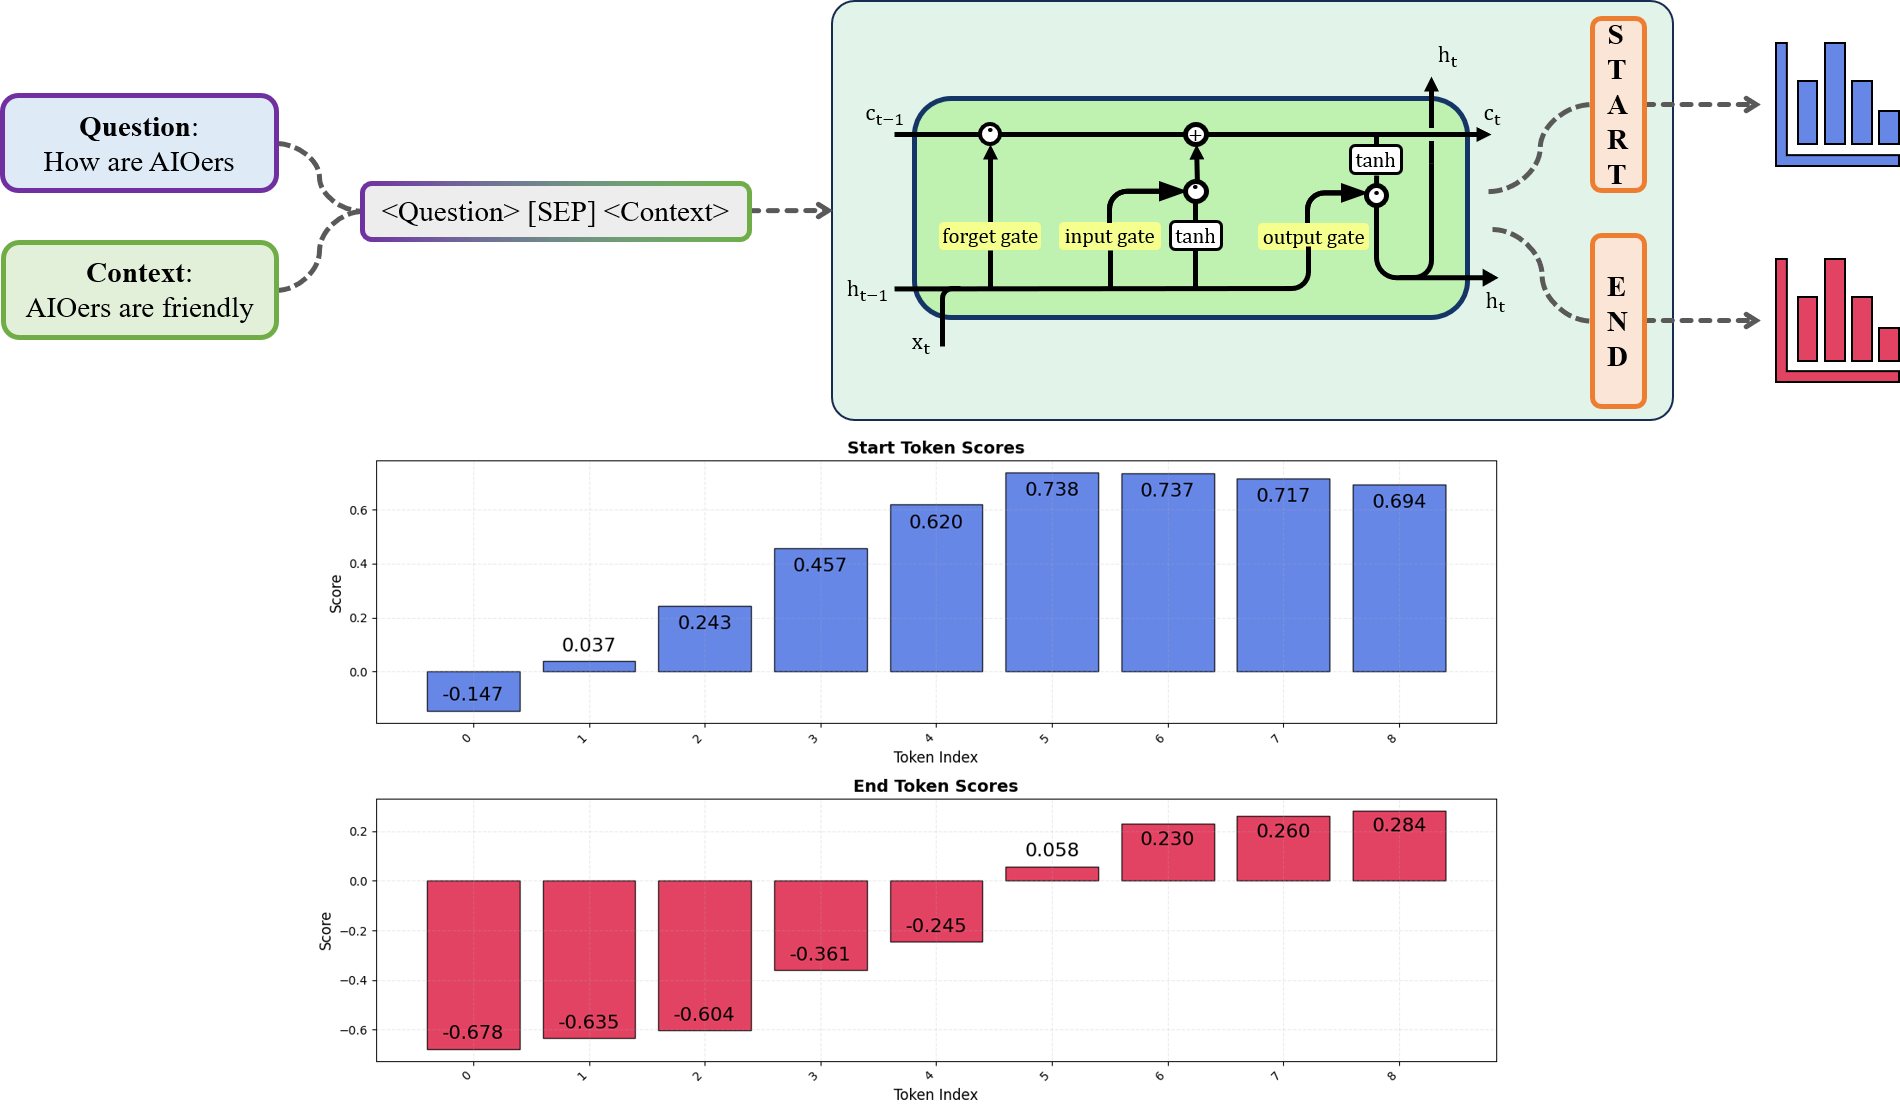

In [ ]:
torch.manual_seed(4)
class QAModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers):
        super(QAModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        print("🟢 Embedding:")
        print(self.embedding.weight, self.embedding.weight.shape)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        print("🟢 LSTM:")
        print(self.lstm.weight_ih_l0, self.lstm.weight_ih_l0.shape)
        print(self.lstm.weight_hh_l0, self.lstm.weight_hh_l0.shape)

        self.fc_start = nn.Linear(hidden_dim * 2, 1)  # Start token scores
        self.fc_end = nn.Linear(hidden_dim * 2, 1)    # End token scores
        print("🟢 FC Start:")
        print(self.fc_start.weight, self.fc_start.weight.shape)

        print("🟢 FC End:")
        print(self.fc_end.weight, self.fc_end.weight.shape)

    def forward(self, input_vector):
        print("🟢 Input Vector:")
        print(input_vector, input_vector.shape)

        input_emb = self.embedding(input_vector)  # (batch, max_seq_length, emb_dim)

        print("🟢 Input Embedding:")
        print(input_emb, input_emb.shape)

        lstm_out, _ = self.lstm(input_emb)
        print("🟣 LSTM Output:")
        print(lstm_out, lstm_out.shape)

        start_scores = self.fc_start(lstm_out).squeeze(-1)  # Predict start positions
        end_scores = self.fc_end(lstm_out).squeeze(-1)      # Predict end positions

        print("🔴 Start Scores:")
        print(start_scores, start_scores.shape)
        print("🔵 End Scores:")
        print(end_scores, end_scores.shape)

        return start_scores, end_scores

In [ ]:
EMBEDDING_DIM = 2
HIDDEN_DIM = 4
VOCAB_SIZE = len(vocab)
N_LAYER = 2

model = QAModel(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, N_LAYER)

🟢 Embedding:
Parameter containing:
tensor([[-0.9414,  1.2632],
        [-0.1838,  0.1505],
        [ 0.1075, -0.2780],
        [-2.6021,  0.6245],
        [-0.8684, -0.2051],
        [ 0.3976,  0.6699],
        [-0.0537,  0.0467],
        [-1.7671, -2.1205]], requires_grad=True) torch.Size([8, 2])
🟢 LSTM:
Parameter containing:
tensor([[ 0.2635, -0.2863],
        [-0.1934, -0.4614],
        [ 0.0220, -0.1793],
        [ 0.1074,  0.0233],
        [ 0.4263,  0.0431],
        [ 0.2506,  0.1578],
        [ 0.4436, -0.2079],
        [ 0.4175,  0.3586],
        [-0.1996,  0.3065],
        [ 0.4622, -0.2827],
        [-0.1950,  0.3421],
        [ 0.4032,  0.1319],
        [ 0.1535,  0.3703],
        [ 0.4382, -0.3162],
        [-0.2057,  0.4210],
        [ 0.2701, -0.2346]], requires_grad=True) torch.Size([16, 2])
Parameter containing:
tensor([[-0.1697,  0.4852, -0.3132,  0.3216],
        [ 0.2901, -0.4795, -0.4991,  0.1660],
        [ 0.2453,  0.4432,  0.0616,  0.3392],
        [-0.3553,  0.2

In [ ]:
EPOCHS = 3
LR = 0.05
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    for input_ids, start_pos, end_pos in train_loader:
        optimizer.zero_grad()
        start_logits, end_logits = model(input_ids)

        loss_start = loss_fn(start_logits, start_pos)
        loss_end = loss_fn(end_logits, end_pos)

        loss = (loss_start + loss_end) / 2

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    losses.append(total_loss)
    print(f"📈 Epoch {epoch}, Loss: {total_loss:.4f}")

🟢 Input Vector:
tensor([[5, 4, 3, 2, 3, 4, 6, 1, 1]]) torch.Size([1, 9])
🟢 Input Embedding:
tensor([[[ 0.3976,  0.6699],
         [-0.8684, -0.2051],
         [-2.6021,  0.6245],
         [ 0.1075, -0.2780],
         [-2.6021,  0.6245],
         [-0.8684, -0.2051],
         [-0.0537,  0.0467],
         [-0.1838,  0.1505],
         [-0.1838,  0.1505]]], grad_fn=<EmbeddingBackward0>) torch.Size([1, 9, 2])
🟣 LSTM Output:
tensor([[[ 0.0103, -0.0021, -0.1745, -0.0382,  0.2313,  0.1459,  0.1872,
           0.0007],
         [ 0.0279, -0.0269, -0.2359, -0.0339,  0.2447,  0.1653,  0.1865,
           0.0152],
         [ 0.0307, -0.0525, -0.2584, -0.0478,  0.2307,  0.1533,  0.1757,
           0.0204],
         [ 0.0358, -0.0683, -0.2738, -0.0372,  0.2187,  0.1339,  0.1749,
           0.0311],
         [ 0.0331, -0.0734, -0.2805, -0.0527,  0.2015,  0.1318,  0.1619,
           0.0302],
         [ 0.0293, -0.0836, -0.2755, -0.0394,  0.1774,  0.0948,  0.1567,
           0.0466],
         [ 0.0165, -

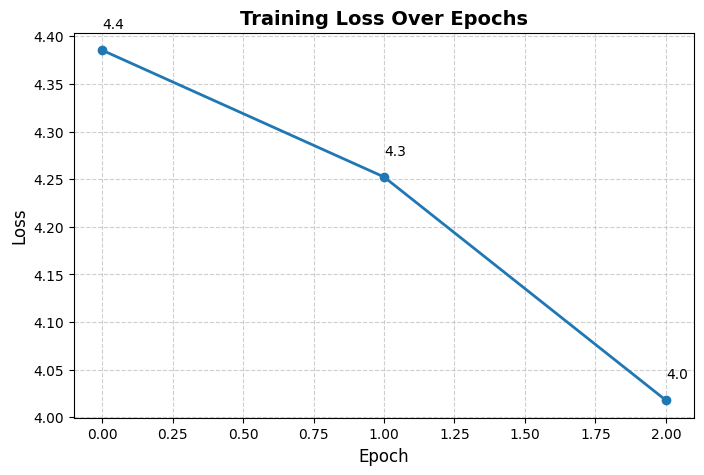

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(losses, marker='o', linestyle='-', linewidth=2, markersize=6)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Over Epochs", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

for i, value in enumerate(losses):
    plt.text(i, value + 0.02, f'{value:.1f}', ha='left', va='bottom', fontsize=10)

plt.show()

In [ ]:
def visualize_scores(sample, model, vocab):
    input_ids, start_pos, end_pos = vectorize(sample, vocab)

    with torch.no_grad():
        start_scores, end_scores = model(input_ids)
        start_scores = start_scores.squeeze().numpy()
        end_scores = end_scores.squeeze().numpy()

    token_labels = [f"{i}" for i in range(len(start_scores))]

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.bar(range(len(start_scores)), start_scores, color="royalblue", alpha=0.8, edgecolor='black')
    plt.xticks(range(len(start_scores)), token_labels, rotation=45, ha="right")
    plt.title("Start Token Scores", fontsize=14, fontweight='bold')
    plt.xlabel("Token Index", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.25)

    for i, v in enumerate(start_scores):
        plt.text(i, (v - 0.1) if v>0.2 else (v + 0.025), f'{v:.3f}', ha='center', va='bottom', fontsize=16)

    plt.subplot(2, 1, 2)
    plt.bar(range(len(end_scores)), end_scores, color="crimson", alpha=0.8, edgecolor='black')
    plt.xticks(range(len(end_scores)), token_labels, rotation=45, ha="right")
    plt.title("End Token Scores", fontsize=14, fontweight='bold')
    plt.xlabel("Token Index", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.25)

    for i, v in enumerate(end_scores):
        plt.text(i, (v - 0.1) if v>0.2 else (v + 0.025), f'{v:.3f}', ha='center', va='bottom', fontsize=16)

    plt.tight_layout()
    plt.show()


In [ ]:
qa_dataset[1]

{'context': 'AIOers are friendly',
 'question': 'How are AIOers',
 'answer': 'friendly',
 'start': 2,
 'end': 2,
 'input_ids': tensor([5, 4, 3, 2, 3, 4, 6, 1, 1]),
 'start_token': tensor(6),
 'end_token': tensor(6)}

Input: How are AIOers <sep> AIOers are friendly
Input Ids: tensor([5, 4, 3, 2, 3, 4, 6, 1, 1])

 Running Inference for Question: How are AIOers

🟢 Input Vector:
tensor([5, 4, 3, 2, 3, 4, 6, 1, 1]) torch.Size([9])
🟢 Input Embedding:
tensor([[ 0.2544,  0.9123],
        [-0.9343,  0.0808],
        [-2.4706,  0.8826],
        [-0.0536,  0.0086],
        [-2.4706,  0.8826],
        [-0.9343,  0.0808],
        [ 0.1644, -0.1679],
        [-0.0889, -0.1257],
        [-0.0889, -0.1257]]) torch.Size([9, 2])
🟣 LSTM Output:
tensor([[-0.1466, -0.0162, -0.2162,  0.2577,  0.8296,  0.3626,  0.8193,  0.0287],
        [-0.4082,  0.0762, -0.2512,  0.3464,  0.8135,  0.3852,  0.7823,  0.0208],
        [-0.6606,  0.0891, -0.2691,  0.4645,  0.7207,  0.4430,  0.7272,  0.0012],
        [-0.7664,  0.2269, -0.3198,  0.3919,  0.4286,  0.4123,  0.5604, -0.0579],
        [-0.8515,  0.1868, -0.2870,  0.4652,  0.1414,  0.4288,  0.4198, -0.0779],
        [-0.8630,  0.3272, -0.2293,  0.2986, -0.1341,  0.3335,  0.2419,

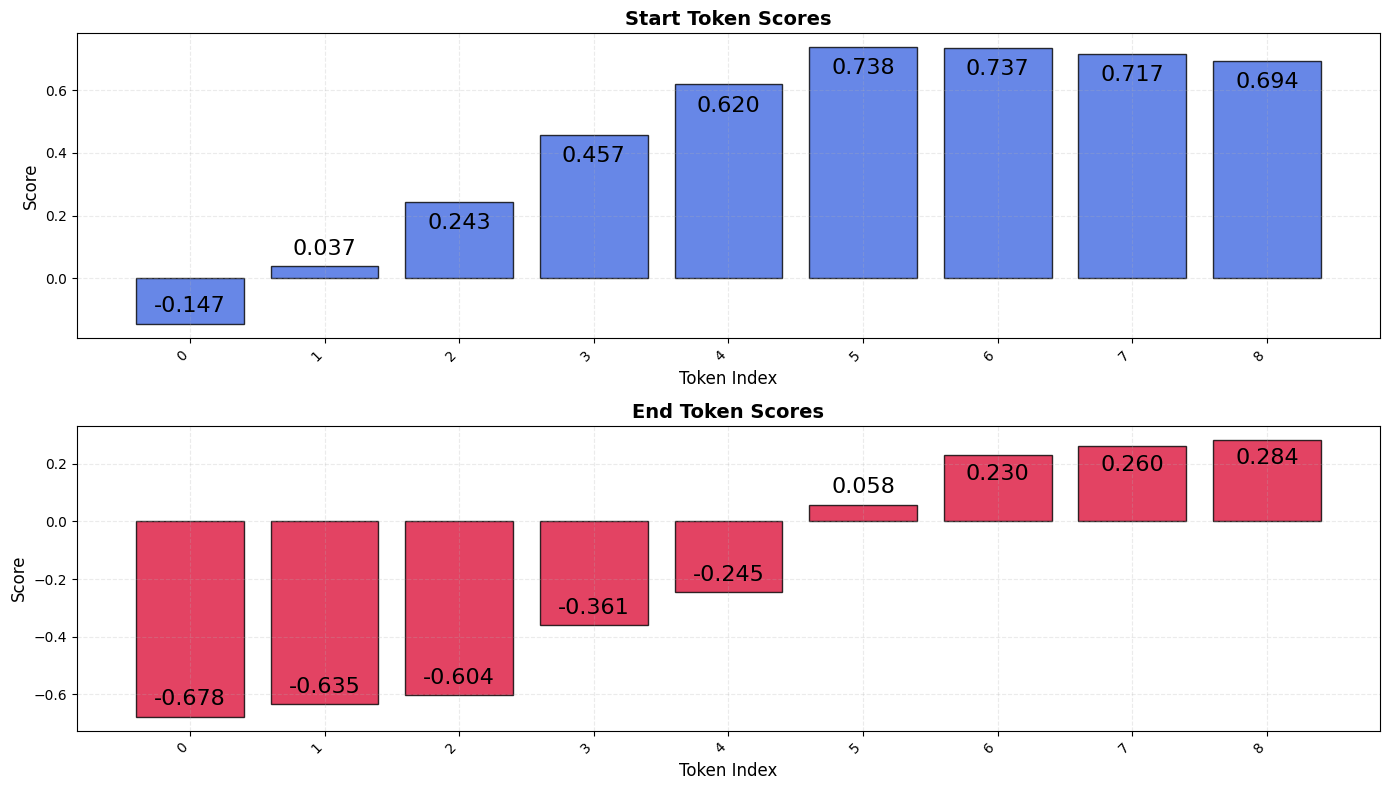

Predicted Start Token Index: 5
Predicted End Token Index: 8
Grouth truth: Start: 6, End: 6

Model predict:  are friendly


In [ ]:
sample = qa_dataset[1]
print(f"Input: {sample['question']} <sep> {sample['context']}")

input_ids, start_pos, end_pos = vectorize(sample, vocab)
print(f"Input Ids: {input_ids}")

with torch.no_grad():
    print(f"\n Running Inference for Question: {sample['question']}\n")
    start_scores, end_scores = model(input_ids)

visualize_scores(sample, model, vocab)

predicted_start = torch.argmax(start_scores).item()
print(f"Predicted Start Token Index: {predicted_start}")
predicted_end = torch.argmax(end_scores).item()
print(f"Predicted End Token Index: {predicted_end}")
print(f"Grouth truth: Start: {sample['start_token']}, End: {sample['end_token']}")

offset = len(tokenizer(sample["question"])) + 1
predicted_answer_tokens = tokenizer(sample["context"])[predicted_start - offset: predicted_end - offset + 1]
print("\nModel predict: ", " ".join(predicted_answer_tokens))

## Câu hỏi 3: **M08QA03**
### Động lực:
Hiện nay các hệ thống QA bằng Retrieval-augmented generation (RAG) đang được cộng đồng đặc biệt quan tâm và phát triển, với số bài báo nghiên cứu tăng thần tốc từ 2 tại năm 2020 lên thành 1202 bài vào năm 2024 (nguồn: https://medium.com/@yu-joshua/2024-the-year-of-rag-part-1-bdf8a05f818d), chính vì thể, câu hỏi này sẽ ôn lại cơ bản các thành phần bên trong một hệ thống RAG.

### Mô tả:
Hình ảnh bên dưới mô tả một hệ thống RAG được triển khai bằng LlamaIndex mà các bạn đã được học và thực hiện trong buổi: *Project: End-to-end Question Answering (Building Searching Tool)*, ***NHƯNG*** có gì đó không đúng lắm ...

### Câu hỏi:
Có tổng cộng bao nhiêu thành phần bị thiếu và sai vị trí trong hình? (mỗi thành phần tương ứng với 1 hình vẽ/icon)

### Chọn đáp án:
A. 5

B. 4

C. 3

D. 2

### Đáp án: A

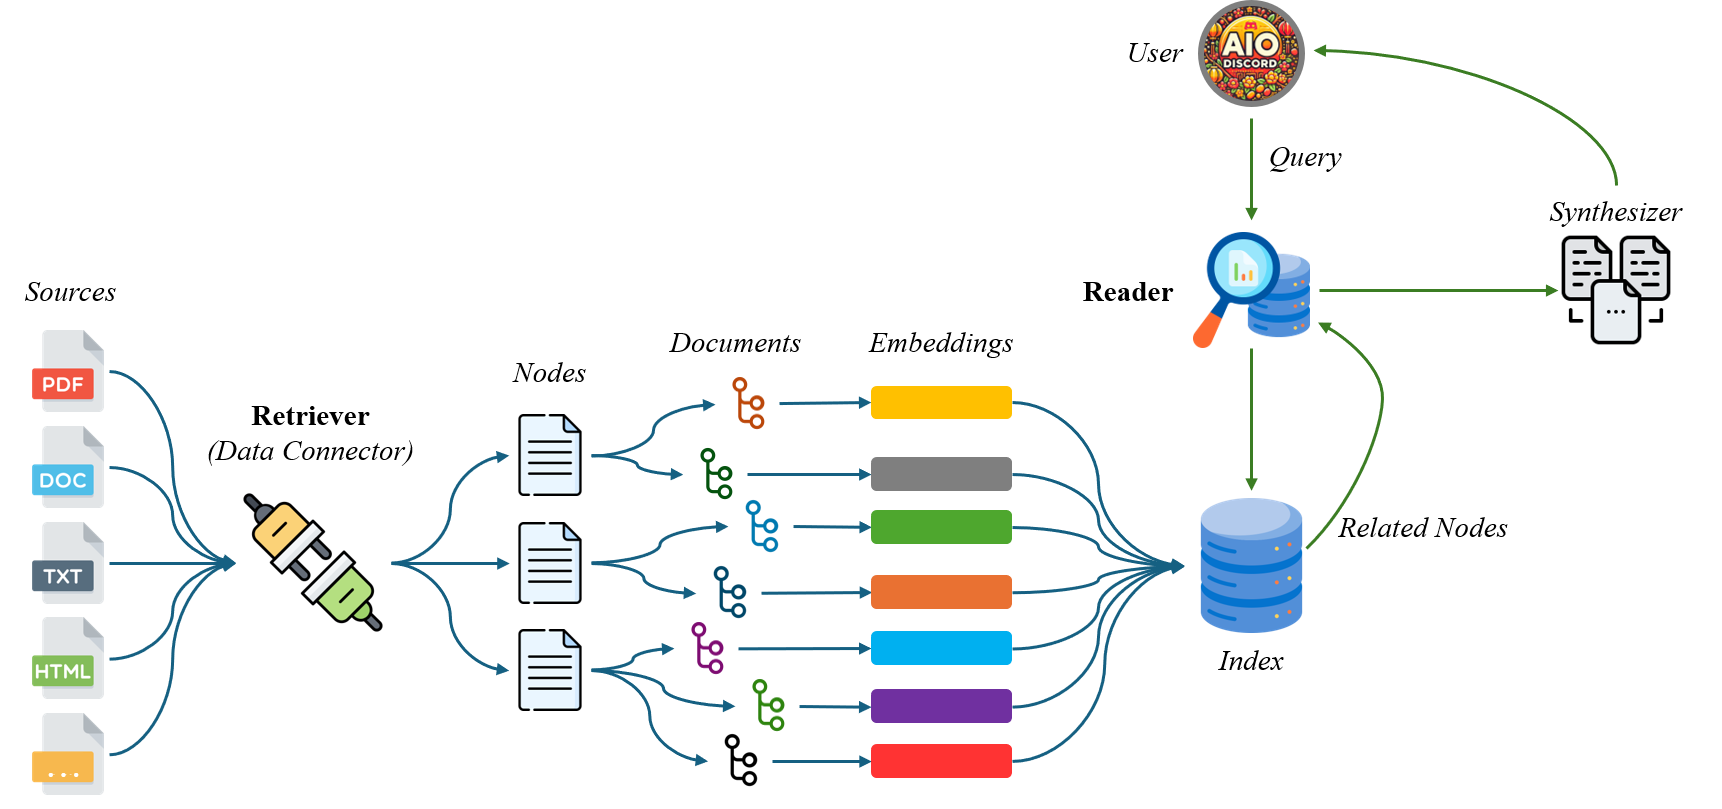

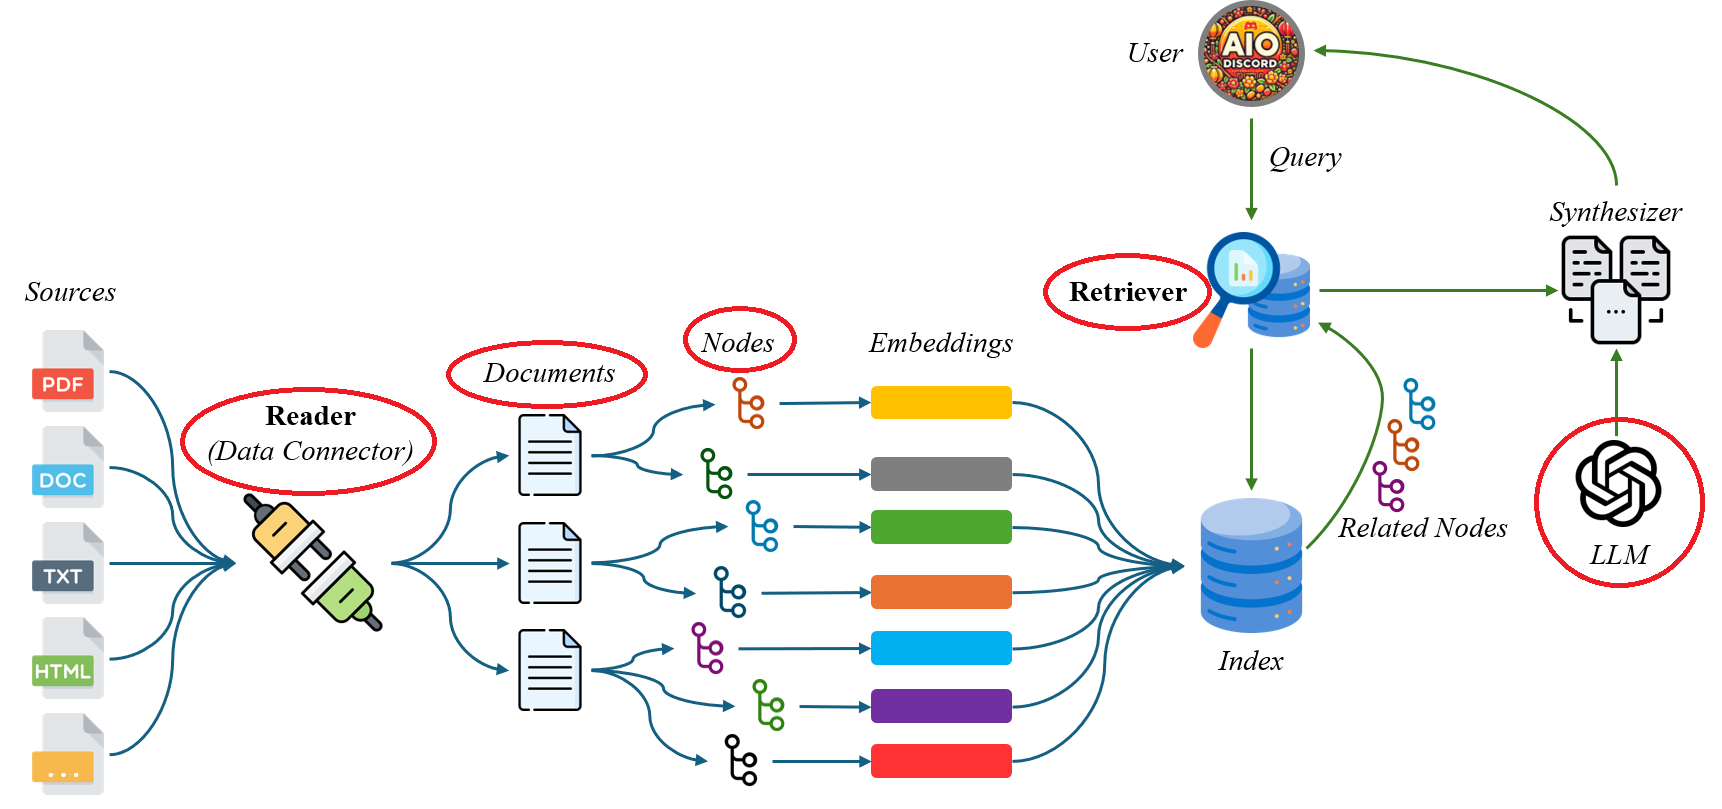